# ERA5 Data

In this notebook we will show how to work with the ERA5 data on the repository.

In [1]:
import os

import cartopy.crs as ccrs  # for mapping
from cartopy.feature import STATES, BORDERS
import dask # for parallel processing
import matplotlib.pyplot as plt  # for plotting
import xarray as xr  # for gridded data

We need to define the folder where the data is located.
See the [documentation](https://kb.rice.edu/page.php?id=108256) for the Rice RDF to learn how to mount the folder on your machine.

In [2]:
era5_dir = "/Volumes/research/jd82/ERA5/"

## Working with multiple variables

One (of many!) interesting things we might want to do is work with multiple variables.
These are all on the same grid, and we want to take advantage of this.

In [3]:
fnames = [
    os.path.join(era5_dir, "pressure_level", "u_component_of_wind_500_2015.nc"),
    os.path.join(era5_dir, "pressure_level", "v_component_of_wind_500_2015.nc"),
]

We tell dask to split large chunks following their tutorial:

In [4]:
dask.config.set({"array.slicing.split_large_chunks": True})

To do read in all these files, we can use the multi-file functionality of xarray.
This uses dask as a backend for lazy loading.
For more, see [the docs](https://docs.xarray.dev/en/stable/user-guide/dask.html)!

In [5]:
ds = xr.open_mfdataset(fnames)

# add in elevation separately to make sure only 1 time index is used
ds["z"] = xr.open_dataarray(os.path.join(era5_dir, "single_level", "elevation.nc")).isel(time=0).drop("time")

# show the dataset
ds

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 101, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    u          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 101, 241), meta=np.ndarray>
    v          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 101, 241), meta=np.ndarray>
    z          (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-10 15:28:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

We can see that the variables are all indexed here.
As in Pandas, we can access them individually to get a `DataArray` object:

In [6]:
ds["u"]

<xarray.DataArray 'u' (time: 8760, latitude: 101, longitude: 241)>
dask.array<open_dataset-179724c71ab8ed2b99d91a59f16d9e40u, shape=(8760, 101, 241), dtype=float32, chunksize=(8760, 101, 241), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

We can also plot these variables

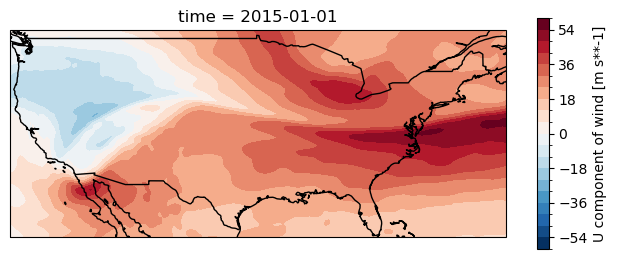

In [7]:
p1 = ds.u.isel(time=0).plot.contourf(levels=21,
subplot_kws=dict(
        projection=ccrs.PlateCarree(),  # desired map
        transform=ccrs.PlateCarree(),  # data projection
    ),
    figsize=(8, 3),)

p1.axes.add_feature(BORDERS)
p1.axes.coastlines()
plt.draw()

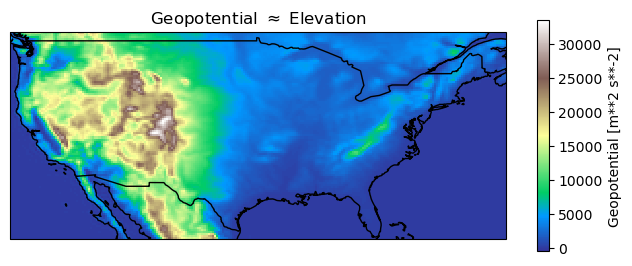

In [8]:
p2 = ds["z"].plot(
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),  # desired map
        transform=ccrs.PlateCarree(),  # data projection
    ),
    figsize=(8, 3),
    cmap="terrain",
    vmin=ds.z.min(),
    vmax=ds.z.max(),
)
p2.axes.add_feature(BORDERS)
p2.axes.coastlines()
plt.title(r"Geopotential $\approx$ Elevation")
plt.draw()